In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.svm import SVC

from sklearn.metrics import roc_auc_score, roc_curve,auc
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score

In [26]:
train = pd.read_csv('/Users/vadimsmirnov/Desktop/Project_ML/train_data_encoded.csv')
validation = pd.read_csv('/Users/vadimsmirnov/Desktop/Project_ML/validation_data_encoded.csv')
test = pd.read_csv('/Users/vadimsmirnov/Desktop/Project_ML/test_data_encoded.csv')

In [27]:
X_train = train.drop(columns = ['target'])
y_train = train['target']

X_valid = validation.drop(columns = ['target'])
y_valid = validation['target']

X_test = test.drop(columns = ['target'])
y_test = test['target']

In [28]:
scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_validation_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [29]:
#Parameter tuning
parameters = {'C':[0.001,0.01,0.05,0.1,0.5,1,5,10,20,30,40,50,60,70,80,90,100]}

In [30]:
lr = LogisticRegression(random_state = 42, class_weight = 'balanced')
cv_lr = GridSearchCV(lr,parameters,cv=5,n_jobs=-1)

cv_lr.fit(X_train_scaled,y_train)
print('The best parameters:\n',cv_lr.best_params_)

The best parameters:
 {'C': 40}


In [31]:
lr_model = LogisticRegression(random_state=42,class_weight = 'balanced', C = cv_lr.best_params_['C'])

lr_model.fit(X_train_scaled,y_train)

LogisticRegression(C=40, class_weight='balanced', random_state=42)

In [32]:
y_predict_train = lr_model.predict_proba(X_train_scaled)
y_predict_valid = lr_model.predict_proba(X_validation_scaled)
y_predict_test = lr_model.predict_proba(X_test_scaled)

train_score_lr = roc_auc_score(y_train,y_predict_train[:,1])
valid_score_lr = roc_auc_score(y_valid,y_predict_valid[:,1])
test_score_lr = roc_auc_score(y_test,y_predict_test[:,1])

print("Training ROC-AUC score of Logistic Regression model: ", train_score_lr)
print("Validation ROC-AUC score of Logistic Regression model: ", valid_score_lr)
print("Test ROC-AUC score of Logistic Regression model: ", test_score_lr)


Training ROC-AUC score of Logistic Regression model:  0.7974597706024826
Validation ROC-AUC score of Logistic Regression model:  0.7968016519861709
Test ROC-AUC score of Logistic Regression model:  0.7820419820407051


In [33]:
#Random Forest
n_estimators = np.arange(0,1001,50)
max_features = ['auto','sqrt']
max_depth = [int(x) for x in np.linspace(5,100,num=10)]
max_depth.append(None)

parameters = {
    'max_features': max_features,
    'n_estimators': n_estimators,
    'max_depth': max_depth
}

parameters

{'max_features': ['auto', 'sqrt'],
 'n_estimators': array([   0,   50,  100,  150,  200,  250,  300,  350,  400,  450,  500,
         550,  600,  650,  700,  750,  800,  850,  900,  950, 1000]),
 'max_depth': [5, 15, 26, 36, 47, 57, 68, 78, 89, 100, None]}

In [34]:
# Model
rf = RandomForestClassifier(random_state=42)
cv_rf = RandomizedSearchCV(rf, parameters, cv=5)

# Find best parameters
cv_rf.fit(X_train_scaled, y_train)
print('The best parameters are: \n', cv_rf.best_params_)

/opt/miniconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/miniconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/miniconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value f

The best parameters are: 
 {'n_estimators': 250, 'max_features': 'sqrt', 'max_depth': 15}


In [35]:
# Retrain model with tuned parameters

rf_model = RandomForestClassifier(
    random_state=42, 
    n_estimators =  cv_rf.best_params_['n_estimators'], 
    max_features =  cv_rf.best_params_['max_features'],
    max_depth =  cv_rf.best_params_['max_depth'],
) 

rf_model.fit(X_train_scaled, y_train)


RandomForestClassifier(max_depth=15, n_estimators=250, random_state=42)

In [37]:
# Model Evaluation 
y_predict_train = rf_model.predict_proba(X_train_scaled)
y_predict_valid = rf_model.predict_proba(X_validation_scaled)
y_predict_test = rf_model.predict_proba(X_test_scaled)

train_score_rf = roc_auc_score(y_train, y_predict_train[:,1])
valid_score_rf = roc_auc_score(y_valid, y_predict_valid[:,1])
test_score_rf = roc_auc_score(y_test, y_predict_test[:,1])
print("Training ROC-AUC score of Random Forest model: ", train_score_rf)
print("Validation ROC-AUC score of Random Forest model: ", valid_score_rf)
print("Test ROC-AUC score of Random Forest model: ", test_score_rf)

Training ROC-AUC score of Random Forest model:  0.9493542984021349
Validation ROC-AUC score of Random Forest model:  0.8045262878006292
Test ROC-AUC score of Random Forest model:  0.7893586191967934


In [38]:
#XGBOOST

In [39]:
# Parameters to tune 
parameters = {
    'learning_rate': [0.01, 0.015, 0.025, 0.05, 0.1, 0.3],
    'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    'max_depth': [3, 4, 6, 8, 10],
    'min_child_weight': [1, 3, 5, 7]
}
parameters

{'learning_rate': [0.01, 0.015, 0.025, 0.05, 0.1, 0.3],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
 'max_depth': [3, 4, 6, 8, 10],
 'min_child_weight': [1, 3, 5, 7]}

In [40]:
# Model
xgbc = xgb.XGBClassifier(random_state = 42, verbosity=0)
cv_xgb = RandomizedSearchCV(xgbc, parameters, cv=5)

# Find best parameters
cv_xgb.fit(X_train_scaled, y_train)

print('The best parameters are: \n', cv_xgb.best_params_)

The best parameters are: 
 {'n_estimators': 400, 'min_child_weight': 7, 'max_depth': 4, 'learning_rate': 0.025}


In [41]:
# Retrain model with tuned parameters

xgb_model = xgb.XGBClassifier(
    random_state=42, 
    learning_rate=cv_xgb.best_params_['learning_rate'],
    n_estimators=cv_xgb.best_params_['n_estimators'],
    max_depth=cv_xgb.best_params_['max_depth'],
    min_child_weight=cv_xgb.best_params_['min_child_weight'], 
    verbosity=0
) 

xgb_model.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [42]:
# Model Evaluation
y_predict_train = xgb_model.predict_proba(X_train_scaled)
y_predict_valid = xgb_model.predict_proba(X_validation_scaled)
y_predict_test = xgb_model.predict_proba(X_test_scaled)

train_score_xgb = roc_auc_score(y_train, y_predict_train[:,1])
valid_score_xgb = roc_auc_score(y_valid, y_predict_valid[:,1])
test_score_xgb = roc_auc_score(y_test, y_predict_test[:,1])
print("Training ROC-AUC score of XGBoost model: ", train_score_xgb)
print("Validation ROC-AUC score of XGBoost model: ", valid_score_xgb)
print("Test ROC-AUC score of XGBoost model: ", test_score_xgb)

Training ROC-AUC score of XGBoost model:  0.8283564591015569
Validation ROC-AUC score of XGBoost model:  0.8059557072844761
Test ROC-AUC score of XGBoost model:  0.7924715190489163


In [43]:
Model_comparison = {
    'model':['Logistic Regression', 'Random Forest',  'XGBoost' ],
    'Train ROC-AUC score':[train_score_lr,  train_score_rf,  train_score_xgb ],
    'Validation ROC-AUC score':[valid_score_lr, valid_score_rf,  valid_score_xgb],
    'Test ROC-AUC score':[test_score_lr, test_score_rf,  test_score_xgb]
}

pd.DataFrame(Model_comparison)

,model,Train ROC-AUC score,Validation ROC-AUC score,Test ROC-AUC score
0,Logistic Regression,0.797460,0.796802,0.782042
1,Random Forest,0.949354,0.804526,0.789359
2,XGBoost,0.828356,0.805956,0.792472


In [44]:
# Calculate inputs for ROC curve Logistic Regression
probs_lr = lr_model.predict_proba(X_test_scaled)
preds_lr = probs_lr[:,1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, preds_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

# Calculate inputs for ROC curve XGBoost
probs_xgb = xgb_model.predict_proba(X_test_scaled)
preds_xgb = probs_xgb[:,1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, preds_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Calculate inputs for ROC curve Random Forest
probs_rf = rf_model.predict_proba(X_test_scaled)
preds_rf = probs_rf[:,1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, preds_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

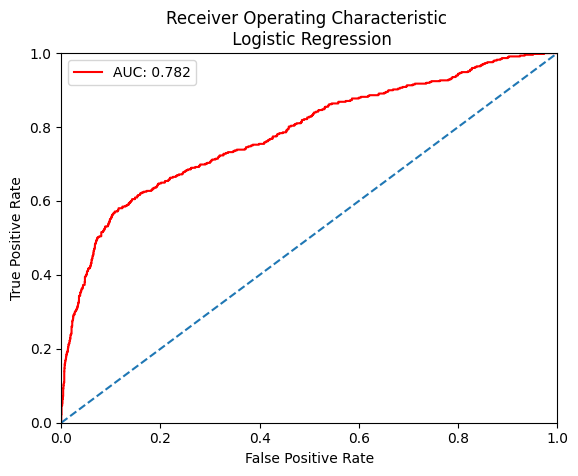

In [45]:
# ROC Curve plot 
plt.title('Receiver Operating Characteristic \n Logistic Regression')
plt.plot(fpr_lr, tpr_lr, 'r', label = 'AUC: '+str(round(roc_auc_lr,4)))
plt.plot([0, 1], [0, 1],'--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

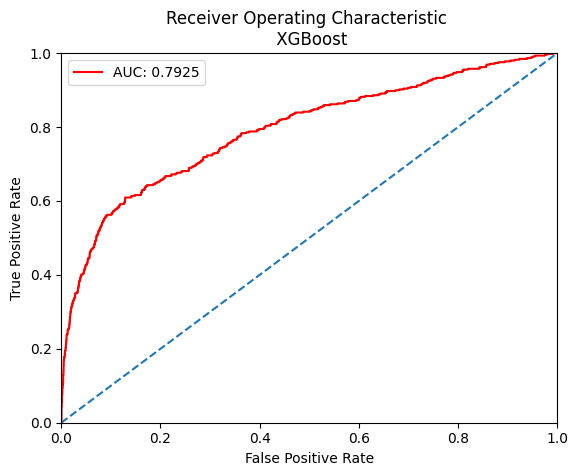

In [46]:
# ROC Curve plot 
plt.title('Receiver Operating Characteristic \n XGBoost')
plt.plot(fpr_xgb, tpr_xgb, 'r', label = 'AUC: '+str(round(roc_auc_xgb,4)))
plt.plot([0, 1], [0, 1],'--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

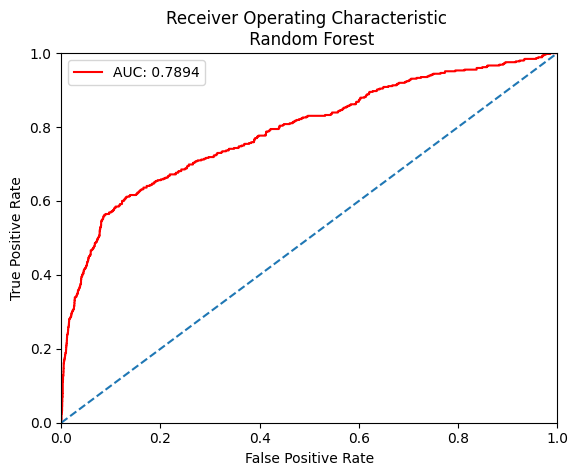

In [47]:
# ROC Curve plot 
plt.title('Receiver Operating Characteristic \n Random Forest')
plt.plot(fpr_rf, tpr_rf, 'r', label = 'AUC: '+str(round(roc_auc_rf,4)))
plt.plot([0, 1], [0, 1],'--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()